In [32]:
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine
import warnings
import psycopg2
import matplotlib.pyplot as plt
import math
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))


df = pd.read_sql_query('select * from useducation', con=engine)

engine.dispose()

In [16]:
clean_df = df.copy()

for state in df.STATE.unique():
    clean_df[clean_df.STATE == state] = df[df.STATE == state].interpolate(limit_direction='both')
    
to_drop_array = []
for state in clean_df[pd.isnull(clean_df.ENROLL) == True].STATE:
    to_drop_array.append(state)
    
rows_to_drop = []
for row_index in range(len(clean_df)):
    if clean_df.STATE[row_index] in to_drop_array:
        rows_to_drop.append(row_index)
        
clean_df = clean_df.drop(clean_df.index[rows_to_drop])
clean_df.reset_index(drop=True, inplace=True)

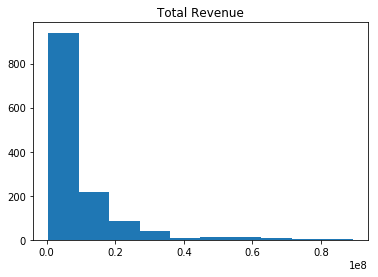

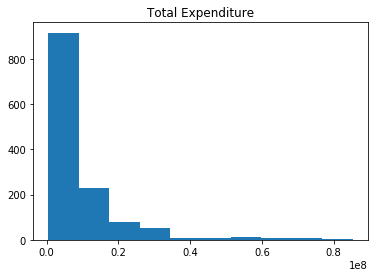

In [17]:
# 1. Consider the two variables: TOTAL_REVENUE and TOTAL_EXPENDITURE. Do these variables have outlier values?
plt.hist(clean_df.TOTAL_REVENUE)
plt.title('Total Revenue')
plt.show()
plt.hist(clean_df.TOTAL_EXPENDITURE)
plt.title('Total Expenditure')
plt.show()

In [21]:
#2 I am going to try to transform these variables first using a log transformation.
revenue_log_list = []
for i in range(len(clean_df.TOTAL_REVENUE)):
    revenue_log_list.append(math.log(clean_df.TOTAL_REVENUE[i]))

clean_df['TOTAL_REVENUE_LOG'] = revenue_log_list

expenditure_log_list = []
for i in range(len(clean_df.TOTAL_EXPENDITURE)):
    expenditure_log_list.append(math.log(clean_df.TOTAL_EXPENDITURE[i]))
    
clean_df['TOTAL_EXPENDITURE_LOG'] = expenditure_log_list

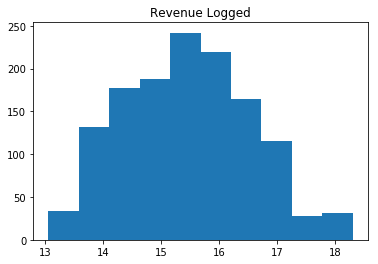

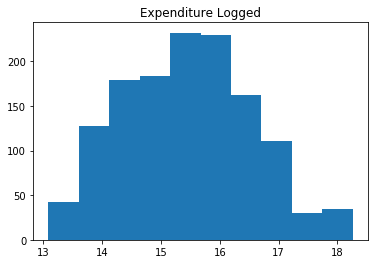

In [22]:
plt.hist(clean_df.TOTAL_REVENUE_LOG)
plt.title('Revenue Logged')
plt.show()
plt.hist(clean_df.TOTAL_EXPENDITURE_LOG)
plt.title('Expenditure Logged')
plt.show()

In [23]:
# 3.
budget_deficit = []
for i in range(len(clean_df)):
    budget_deficit.append(clean_df.TOTAL_REVENUE[i] - clean_df.TOTAL_EXPENDITURE[i])
clean_df['BUDGET_DEFICIT'] = budget_deficit

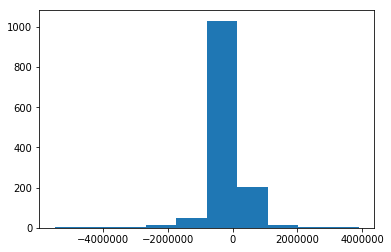

In [25]:
plt.hist(clean_df.BUDGET_DEFICIT)
plt.show()

In [31]:
np.where(zscore(clean_df.BUDGET_DEFICIT) > 1.5)

(array([  96,  264,  316,  373,  420,  472,  791,  816,  868,  902,  955,
         974,  996, 1002, 1005, 1006, 1014, 1056, 1057, 1074, 1110, 1118,
        1161, 1169, 1182, 1212, 1220, 1233, 1253, 1263, 1271, 1290, 1300,
        1308]),)

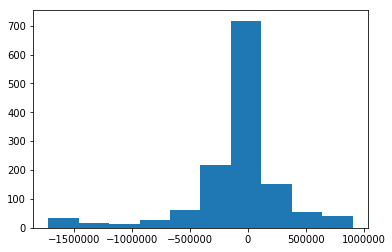

In [60]:
winsorized_deficits = winsorize(clean_df.BUDGET_DEFICIT, (.02, .02))
clean_df['WINSORIZED_DEFICITS'] = winsorized_deficits
plt.hist(clean_df.WINSORIZED_DEFICITS)
plt.show()

In [55]:
#4
budget_deficit = []
for i in range(len(clean_df)):
    budget_deficit.append(clean_df.TOTAL_REVENUE_LOG[i] - clean_df.TOTAL_EXPENDITURE_LOG[i])
clean_df['BUDGET_DEFICIT_LOG'] = budget_deficit

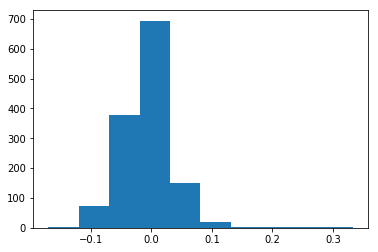

In [56]:
plt.hist(clean_df.BUDGET_DEFICIT_LOG)
plt.show()

In [57]:
winsorized_deficits_from_logs = winsorize(clean_df.BUDGET_DEFICIT_LOG, (.02, .02))
clean_df['WINSORIZED_DEFICITS_FROM_LOGS'] = winsorized_deficits_from_logs

In [58]:
#5
clean_df.WINSORIZED_DEFICITS_FROM_LOGS.describe()

count    1331.000000
mean       -0.006415
std         0.037688
min        -0.093278
25%        -0.028524
50%        -0.005773
75%         0.015942
max         0.088538
Name: WINSORIZED_DEFICITS_FROM_LOGS, dtype: float64

In [59]:
clean_df.WINSORIZED_DEFICITS.describe()

count    1.331000e+03
mean    -8.714904e+04
std      4.204323e+05
min     -1.723468e+06
25%     -1.808230e+05
50%     -1.891500e+04
75%      5.795900e+04
max      9.040780e+05
Name: WINSORIZED_DEFICITS, dtype: float64

In [ ]:
# The from logs version is centered at 0 and skewed right, and the normal winsorized version is skewed left.
# The scale is very different due to the log transformations.
# 6. Due to my methods, the non-logged version looks better to be honest because it's at the correct scale already.
# If I just cared about the distribution of the single variables the logs would be better though.